In [12]:
#SPOTIFY FEATURES
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import os


# Scraping top songs from spotifycharts.com for the week of 2019-01-25

In [13]:
# All country codes list used on spotifycharts.com

country_codes_all = ['ad', 'ar', 'at', 'au', 'be', 'bg', 'bo', 'br', 'ca', 'ch', 'cl', 'co', 'cr',
                 'cy', 'cz', 'de', 'dk', 'do', 'ec', 'ee', 'es', 'fi', 'fr', 'gb', 'gr', 'gt',
                 'hk', 'hn', 'hu', 'id', 'ie', 'il', 'is', 'it', 'jp', 'lt', 'lu', 'lv', 'mc',
                 'mt', 'mx','my', 'ni', 'nl', 'no', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'py',
                 'ro', 'se', 'sg', 'sk', 'sv', 'th', 'tr', 'tw', 'us', 'uy', 'vn']

# Clean List of country codes - Removed ad & mc because they had no data for last week - see counter below
country_codes = ['ar', 'at', 'au', 'be', 'bg', 'bo', 'br', 'ca', 'ch', 'cl', 'co', 'cr',
                 'cy', 'cz', 'de', 'dk', 'do', 'ec', 'ee', 'es', 'fi', 'fr', 'gb', 'gr', 'gt',
                 'hk', 'hn', 'hu', 'id', 'ie', 'il', 'is', 'it', 'jp', 'lt', 'lu', 'lv',
                 'mt', 'mx','my', 'ni', 'nl', 'no', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'py',
                 'ro', 'se', 'sg', 'sk', 'sv', 'th', 'tr', 'tw', 'us', 'uy', 'vn']

In [14]:
# Webscraping from spotifycharts.com

#Loop to scrape top 10 songs (out of 200) by country and add Ids to a list for each country
top10_bycountry = {}
for country in country_codes:
    charts = f'https://spotifycharts.com/regional/{country}/weekly/2019-01-25--2019-02-01'
    html_page = requests.get(charts) #Make a get request to retrieve the page
    soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing
    
    top_links = []
    top10_links = []
    for link in soup.findAll('a',target="_blank"):
        top_links.append((link.get('href')))
        top10_links = top_links[1:11]        #Retaining 10 songs out of top 200

    top10_ids = []
    for x in top10_links:
        x = x[-22:]                  #Last 22 digits contain the track ID
        top10_ids.append(x)
    top10_bycountry[country] = top10_ids

In [15]:
# Counting which country returns empty ID for the week

counter = 0
for k,v in top10_bycountry.items():
    if len(v) == 0:
        print(k)
        counter +=1
counter

0

In [16]:
# Keeping a subset of unique track IDs for the API Call
all_songs = []
for n in list(top10_bycountry.values()):
    for x in n:
        all_songs.append(x)
unique = list(set(all_songs))           # Unique list of track IDs

# API call to Spotify

In [17]:
#Credentials - Oauth to access track features
client_id =  '-'
secret = '-'

Oauth ='-'


In [18]:
#Splitting unique songs into two lists because limit per request is 100

first = unique[:100]
second = unique[100:]

#Creating comma separated string of tracks to pass into API calls for the tracks_ids parameter
i = ''
for x in first:
    if x == first[-1]:
        i = i+x
    else:
        i = i+x+','
j = ''
for x in second:
    if x == second[-1]:
        j = j+x
    else:
        j = j+x+','
both = [i,j]

In [19]:
# API call to Spotify to get track features of songs
# Maximum of 100 tracks per API call, loop into "both" list because we have a total of 184 unique tracks

def spotify_call(both):
    result = []
    for x in both:
        track_ids = x
        url= 'https://api.spotify.com/v1/audio-features'
        headers = {"Authorization": "Bearer {}".format(Oauth),}
        url_params = {'ids' : track_ids.replace(' ', '+'),}
        response = requests.get(url,headers=headers,params= url_params)
        result.append(response.json()) 
    return result

In [20]:
# Results of API call
a = spotify_call(both)

In [21]:
# Concatenating the two lists resulting from API call into 1 dataframe.

df1 = pd.DataFrame(a[0]['audio_features'])
df2 = pd.DataFrame(a[1]['audio_features'])
df = pd.concat([df1,df2])

In [22]:
# Checking for incomplete data, column names and making sure total matches number of unique tracks
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 83
Data columns (total 18 columns):
acousticness        184 non-null float64
analysis_url        184 non-null object
danceability        184 non-null float64
duration_ms         184 non-null int64
energy              184 non-null float64
id                  184 non-null object
instrumentalness    184 non-null float64
key                 184 non-null int64
liveness            184 non-null float64
loudness            184 non-null float64
mode                184 non-null int64
speechiness         184 non-null float64
tempo               184 non-null float64
time_signature      184 non-null int64
track_href          184 non-null object
type                184 non-null object
uri                 184 non-null object
valence             184 non-null float64
dtypes: float64(9), int64(4), object(5)
memory usage: 27.3+ KB


In [23]:
# Transpose column countries into row names. Columns become the ranking of top10 by country
top10_byct_df = (pd.DataFrame(top10_bycountry)).T
top10_byct_df.head()

,0,1,2,3,4,5,6,7,8,9
ar,5iwz1NiezX7WWjnCgY5TH4,6FyRXC8tJUh863JCkyWqtk,0s5DNDV6LAKn2u2Ufa3VjQ,6MJUCumnQsQEKbCy28tbCP,3dLiBBKbeUIhzGNeuo5JGS,116H0KvKr2Zl4RPuVBruDO,5W83ErFkO3aKAIS1WMi6u0,2D3z17LBMJ2HEHeBFFjTLi,22sESxzbY1O1E19xjOTaYf,4w8niZpiMy6qz1mntFA5uM
at,7r55d7IhAj5UGKiYbXBwRP,260R90ctQ1SiPax90PuEsT,14msK75pk3pA33pzPVNtBF,7KPGeiXWDsGEvFK62wzU8E,25sgk305KZfyuqVBQIahim,63THFs9ovzO3WQsz4lzh0H,1rqqCSm0Qe4I9rUvWncaom,1IPRghUN3LFPNbCTsfBJx9,2PAYSgrVOBz8RJqp9B7QLu,5z3vuYzS9UF6rD6TmBEdUf
au,14msK75pk3pA33pzPVNtBF,3KkXRkHbMCARz0aVfEt68P,6MWtB6iiXyIwun0YzU6DFP,5p7ujcrUXASCNwRaWNHR1C,6Qs4SXO9dwPj5GKvVOv8Ki,25sgk305KZfyuqVBQIahim,2rPE9A1vEgShuZxxzR2tZH,2xLMifQCjDGFmkHkpNLD9h,7FGq80cy8juXBCD2nrqdWU,7to68V64Cu6zk0UDo5tyw3
be,14msK75pk3pA33pzPVNtBF,25sgk305KZfyuqVBQIahim,1rqqCSm0Qe4I9rUvWncaom,5p7ujcrUXASCNwRaWNHR1C,2VxeLyX666F8uXCJ0dZF8B,6MWtB6iiXyIwun0YzU6DFP,3EPXxR3ImUwfayaurPi3cm,2rPE9A1vEgShuZxxzR2tZH,5itOtNx0WxtJmi1TQ3RuRd,6Qs4SXO9dwPj5GKvVOv8Ki
bg,14msK75pk3pA33pzPVNtBF,5p7ujcrUXASCNwRaWNHR1C,6MWtB6iiXyIwun0YzU6DFP,2JvzF1RMd7lE3KmFlsyZD8,7wFybC8jBH3zE139OpCtpG,2xLMifQCjDGFmkHkpNLD9h,2VxeLyX666F8uXCJ0dZF8B,2IRZnDFmlqMuOrYOLnZZyc,6Qs4SXO9dwPj5GKvVOv8Ki,54ikdt0wnIMn8sT9NFgFSS


In [24]:
# Stacking in order to be able to merge with the track Id features obtained from Spotify
stacked_df = top10_byct_df.stack()
df3 = pd.DataFrame(stacked_df.rename('id'))
df3.head()

id
ar 0  5iwz1NiezX7WWjnCgY5TH4
   1  6FyRXC8tJUh863JCkyWqtk
   2  0s5DNDV6LAKn2u2Ufa3VjQ
   3  6MJUCumnQsQEKbCy28tbCP
   4  3dLiBBKbeUIhzGNeuo5JGS

In [25]:
#To put back country codes & rankings as column names
df3.reset_index(inplace=True)
df3.head()

,level_0,level_1,id
0,ar,0,5iwz1NiezX7WWjnCgY5TH4
1,ar,1,6FyRXC8tJUh863JCkyWqtk
2,ar,2,0s5DNDV6LAKn2u2Ufa3VjQ
3,ar,3,6MJUCumnQsQEKbCy28tbCP
4,ar,4,3dLiBBKbeUIhzGNeuo5JGS


In [26]:
# Renaming column names
df3.rename(columns={'level_0':'code','level_1':'ranking'},inplace=True)
df3.head()

,code,ranking,id
0,ar,0,5iwz1NiezX7WWjnCgY5TH4
1,ar,1,6FyRXC8tJUh863JCkyWqtk
2,ar,2,0s5DNDV6LAKn2u2Ufa3VjQ
3,ar,3,6MJUCumnQsQEKbCy28tbCP
4,ar,4,3dLiBBKbeUIhzGNeuo5JGS


# Merging data from spotifycharts.com to audio features from spotify.com

In [27]:
# Merging table df3 containing country top 10 songs to table df containing music features
merged_top10_features = df3.merge(df,how='left')

In [28]:
merged_top10_features.head()

,code,ranking,id,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,ar,0,5iwz1NiezX7WWjnCgY5TH4,0.323,https://api.spotify.com/v1/audio-analysis/5iwz...,0.826,238200,0.773,0.000000,11,0.1430,-4.218,0,0.0524,126.899,4,https://api.spotify.com/v1/tracks/5iwz1NiezX7W...,audio_features,spotify:track:5iwz1NiezX7WWjnCgY5TH4,0.761
1,ar,1,6FyRXC8tJUh863JCkyWqtk,0.323,https://api.spotify.com/v1/audio-analysis/6FyR...,0.767,258639,0.709,0.000000,1,0.0676,-4.470,1,0.3360,171.993,4,https://api.spotify.com/v1/tracks/6FyRXC8tJUh8...,audio_features,spotify:track:6FyRXC8tJUh863JCkyWqtk,0.720
2,ar,2,0s5DNDV6LAKn2u2Ufa3VjQ,0.146,https://api.spotify.com/v1/audio-analysis/0s5D...,0.709,204453,0.771,0.000003,7,0.2490,-4.598,1,0.1660,174.006,4,https://api.spotify.com/v1/tracks/0s5DNDV6LAKn...,audio_features,spotify:track:0s5DNDV6LAKn2u2Ufa3VjQ,0.709
3,ar,3,6MJUCumnQsQEKbCy28tbCP,0.291,https://api.spotify.com/v1/audio-analysis/6MJU...,0.788,207853,0.771,0.000056,4,0.1720,-3.206,0,0.0563,99.038,4,https://api.spotify.com/v1/tracks/6MJUCumnQsQE...,audio_features,spotify:track:6MJUCumnQsQEKbCy28tbCP,0.701
4,ar,4,3dLiBBKbeUIhzGNeuo5JGS,0.420,https://api.spotify.com/v1/audio-analysis/3dLi...,0.641,244771,0.652,0.000002,8,0.0940,-8.575,0,0.2640,175.022,4,https://api.spotify.com/v1/tracks/3dLiBBKbeUIh...,audio_features,spotify:track:3dLiBBKbeUIhzGNeuo5JGS,0.406


In [29]:
# To make the column "code" more readable and for mapping to country name in the next step
country_names = pd.read_csv('country_codes.csv',encoding='latin-1')
country_names.head()

,code,country
0,ad,Andorra
1,ae,United Arab Emirates
2,af,Afghanistan
3,ag,Antigua and Barbuda
4,ai,Anguilla


In [30]:
# Merging country names into table and dropping "code" column
merged_top10_feat = merged_top10_features.merge(country_names,how='left')
merged_top10_feat.set_index('country',inplace=True)        # setting index column to country
merged_top10_feat.drop('code',axis = 1, inplace=True)      # removing redundant country code information   
merged_top10_feat.ranking = merged_top10_feat.ranking.apply(lambda x: x+1)
merged_top10_feat.head()

,ranking,id,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
country,,,,,,,,,,,,,,,,,,,
Argentina,1,5iwz1NiezX7WWjnCgY5TH4,0.323,https://api.spotify.com/v1/audio-analysis/5iwz...,0.826,238200,0.773,0.000000,11,0.1430,-4.218,0,0.0524,126.899,4,https://api.spotify.com/v1/tracks/5iwz1NiezX7W...,audio_features,spotify:track:5iwz1NiezX7WWjnCgY5TH4,0.761
Argentina,2,6FyRXC8tJUh863JCkyWqtk,0.323,https://api.spotify.com/v1/audio-analysis/6FyR...,0.767,258639,0.709,0.000000,1,0.0676,-4.470,1,0.3360,171.993,4,https://api.spotify.com/v1/tracks/6FyRXC8tJUh8...,audio_features,spotify:track:6FyRXC8tJUh863JCkyWqtk,0.720
Argentina,3,0s5DNDV6LAKn2u2Ufa3VjQ,0.146,https://api.spotify.com/v1/audio-analysis/0s5D...,0.709,204453,0.771,0.000003,7,0.2490,-4.598,1,0.1660,174.006,4,https://api.spotify.com/v1/tracks/0s5DNDV6LAKn...,audio_features,spotify:track:0s5DNDV6LAKn2u2Ufa3VjQ,0.709
Argentina,4,6MJUCumnQsQEKbCy28tbCP,0.291,https://api.spotify.com/v1/audio-analysis/6MJU...,0.788,207853,0.771,0.000056,4,0.1720,-3.206,0,0.0563,99.038,4,https://api.spotify.com/v1/tracks/6MJUCumnQsQE...,audio_features,spotify:track:6MJUCumnQsQEKbCy28tbCP,0.701
Argentina,5,3dLiBBKbeUIhzGNeuo5JGS,0.420,https://api.spotify.com/v1/audio-analysis/3dLi...,0.641,244771,0.652,0.000002,8,0.0940,-8.575,0,0.2640,175.022,4,https://api.spotify.com/v1/tracks/3dLiBBKbeUIh...,audio_features,spotify:track:3dLiBBKbeUIhzGNeuo5JGS,0.406


In [31]:
merged_top10_feat.describe()

,ranking,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,5.500000,0.308698,0.733415,202230.975410,0.601713,0.003113,5.583607,0.146158,-6.370928,0.572131,0.129695,112.856751,3.993443,0.515632
std,2.874639,0.208780,0.101150,35448.377801,0.169395,0.037621,3.696232,0.100210,2.481210,0.495176,0.098184,28.826419,0.140219,0.209555
min,1.000000,0.001350,0.363000,138706.000000,0.104000,0.000000,0.000000,0.050500,-14.221000,0.000000,0.024900,70.142000,3.000000,0.082700
25%,3.000000,0.149000,0.709000,178640.000000,0.488000,0.000000,1.000000,0.088400,-7.399000,0.000000,0.052400,95.239000,4.000000,0.334000
50%,5.500000,0.295500,0.751000,201661.000000,0.600500,0.000000,6.000000,0.105500,-5.982000,1.000000,0.087100,102.211000,4.000000,0.513000
75%,8.000000,0.480000,0.807000,216175.000000,0.750000,0.000006,8.000000,0.172000,-4.470000,1.000000,0.178000,133.002000,4.000000,0.701000
max,10.000000,0.979000,0.937000,354320.000000,0.988000,0.626000,11.000000,0.866000,-1.594000,1.000000,0.425000,194.115000,5.000000,0.962000


In [55]:
# Counting occurence of track Ids in top 10 
song_counts = merged_top10_feat['id'].value_counts()
song_counts = song_counts.rename_axis('unique_track_ids').reset_index(name='counts')
song_counts.head()

,unique_track_ids,counts
0,14msK75pk3pA33pzPVNtBF,46
1,5p7ujcrUXASCNwRaWNHR1C,32
2,6MWtB6iiXyIwun0YzU6DFP,28
3,3KkXRkHbMCARz0aVfEt68P,25
4,6Qs4SXO9dwPj5GKvVOv8Ki,23


In [33]:
# Table summarizing mean features for top 10 grouped by country - Main dataframe
average_features = merged_top10_feat.groupby('country').mean()

In [42]:
# Sorting the danceability feature
sorted_dance = (average_features.sort_values('danceability',ascending = True))

In [68]:
# Counting occurence of modes (major vs minor)
song_mode = merged_top10_feat['mode'].value_counts()
song_mode.head()

1    349
0    261
Name: mode, dtype: int64

# Visualization

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

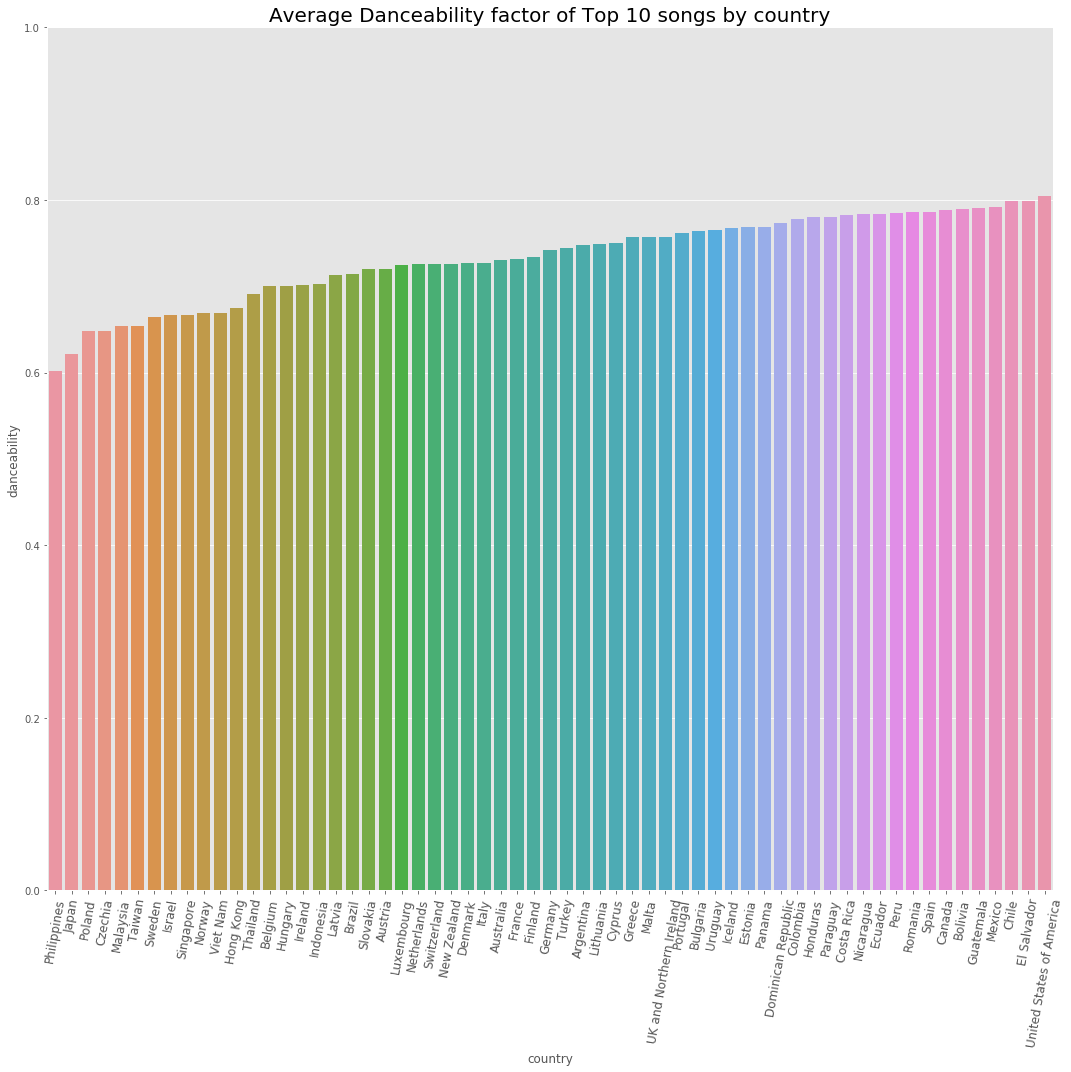

In [43]:
# Barplot of average danceability 
plt.style.use("ggplot")
plt.figure(figsize=(15,15))

danceability_plot = sns.barplot(x=sorted_dance.index,
                           y=sorted_dance.danceability,
                          )
plt.ylim([0,1])
plt.xticks(rotation=80, size = 12)
plt.title('Average Danceability factor of Top 10 songs by country',size=20)
plt.tight_layout()

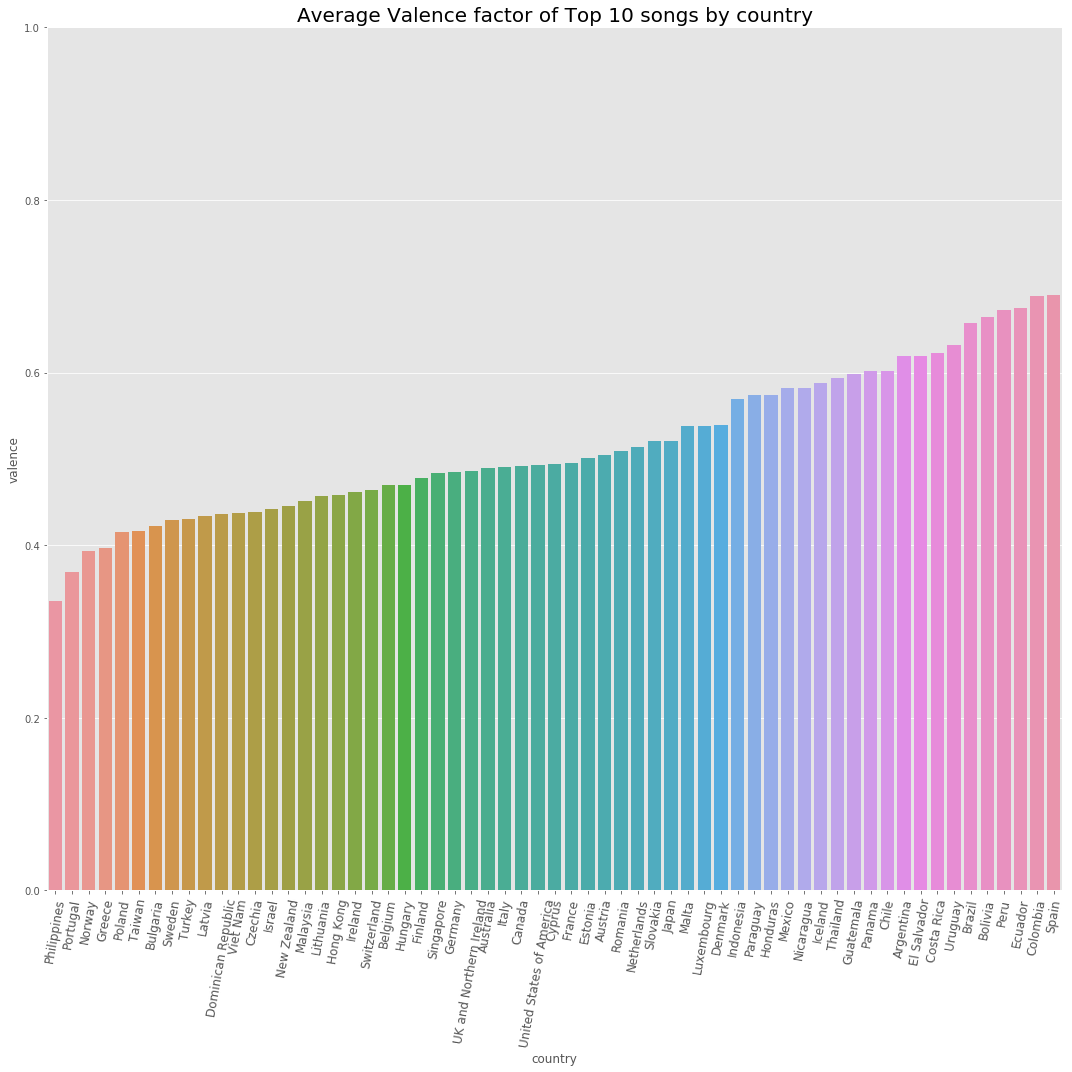

In [44]:
# Barplot of average valence
sorted_valence = (average_features.sort_values('valence',ascending = True))

plt.figure(figsize=(15,15))

valence_plot = sns.barplot(x=sorted_valence.index,
                           y=sorted_valence.valence,
                           )
plt.ylim([0,1])
plt.xticks(rotation=80, size = 12)
plt.title('Average Valence factor of Top 10 songs by country',size=20)
plt.tight_layout()

<Figure size 936x936 with 0 Axes>

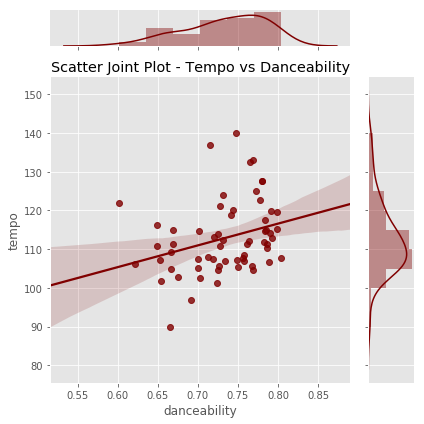

In [51]:
# Jointplot tempo vs danceability
plt.figure(figsize=(13,13))
dance_tempo = sns.jointplot(x=average_features.danceability,
                         y=average_features.tempo, kind="reg",
                        color = 'maroon')
plt.title('Scatter Joint Plot - Tempo vs Danceability')
plt.tight_layout()

In [46]:
#Dataframe to compare correlation between audio features

correl = average_features.drop(['ranking','key','time_signature','mode'],axis = 1)
correl.head()


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
country,,,,,,,,,,
Argentina,0.250260,0.7474,217217.1,0.7308,0.000919,0.12684,-4.7433,0.16828,140.0457,0.6188
Australia,0.301093,0.7310,199032.7,0.5676,0.000001,0.12723,-6.9632,0.13126,112.4793,0.4896
Austria,0.307620,0.7202,181236.6,0.6754,0.000005,0.12119,-6.1327,0.19563,113.0906,0.5042
Belgium,0.311410,0.7005,192785.7,0.5981,0.000052,0.12304,-6.2793,0.09154,107.5602,0.4700
Bolivia,0.214670,0.7896,221053.8,0.7471,0.000921,0.11062,-4.1762,0.13470,114.3072,0.6644


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

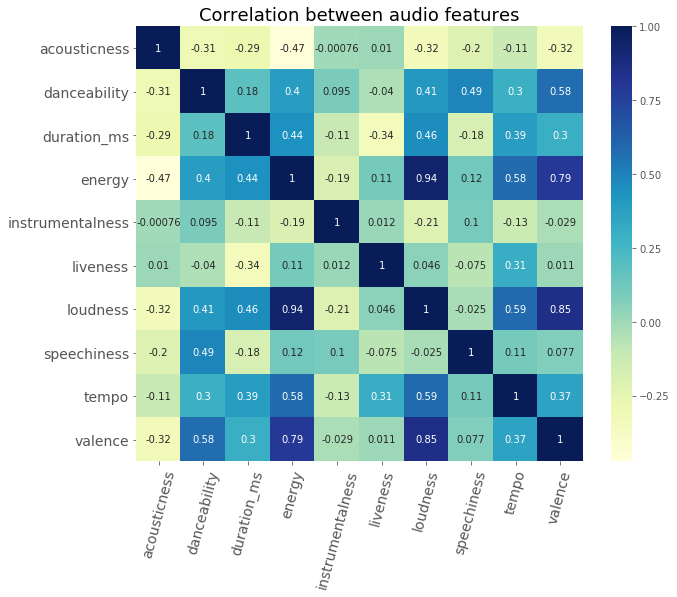

In [47]:
# Heatmap to compare correlation between features

plt.figure(figsize=(10,8))
correl_heatmp = sns.heatmap(correl.corr(),cmap="YlGnBu",annot=True)
plt.title('Correlation between audio features', size = 18)
plt.xticks(rotation=75, size = 14)
plt.yticks(size = 14)

<Figure size 936x936 with 0 Axes>

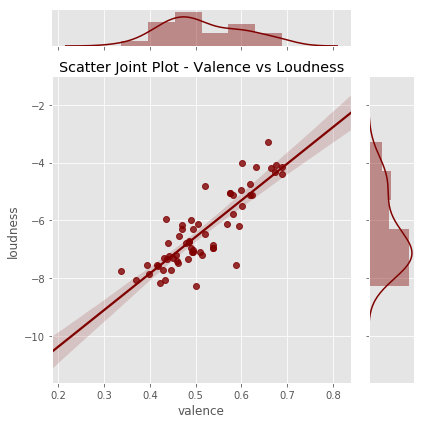

In [56]:
# Jointplot valence & loudness
plt.figure(figsize=(13,13))
val_loud = sns.jointplot(x=average_features.valence,
                         y=average_features.loudness, kind="reg",
                        color = 'maroon')
plt.title('Scatter Joint Plot - Valence vs Loudness')
plt.tight_layout()
plt.savefig('Valence_Loudness'+'.png')

In [49]:
#Saving Final dataframes as .csv files

merged_top10_feat.to_csv("merged_top10_feat.csv")
average_features.to_csv("average_features.csv")
correl.to_csv("correlation_df.csv")
song_counts.to_csv("song_counts.csv")